This notebook contains the series of experiemnts conducted on the 10 images (+2 exemplar images) taken from a single batch.

# Mount Google Drive and Import Dependencies

In [1]:
%load_ext autoreload
%autoreload 2

root_path = '/content/drive/MyDrive/ECE MEng Courses/ECE2500/LearningToCountEverything'
from google.colab import drive
drive.mount('/content/drive')
import sys
from pathlib import Path
sys.path.append(root_path)
%cd '/content/drive/MyDrive/ECE MEng Courses/ECE2500/LearningToCountEverything'

Mounted at /content/drive
/content/drive/MyDrive/ECE MEng Courses/ECE2500/LearningToCountEverything


In [2]:
import BubbleCount.image_preprocess as image_preprocess
import BubbleCount.csv_helpers as csv_helpers
from BubbleCount.post_processing import get_normalized_mse

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw
%matplotlib inline

print("All Dependencies are imported.")

All Dependencies are imported.


# Process Ground Truth
12 images, 6 human counters.

In [4]:
file_path = "Targets/1-Batch Manual Counts/SEN9_1.8_6_300-400_Test/GroundTruth.csv"
df_gt = pd.read_csv(file_path, index_col=0)
df_gt.index = df_gt.index + 1
print(df_gt)

       count_ew  count_ao  count_saeid  count_tony  count_nick  count_jl
image                                                                   
1           152       110          142         149         144       174
2           105        98          100         122         117       157
3           120       111          119         131         135       171
4           127       123          117         148         146       175
5           127       134          113         130         143       163
6           100       104           83         140         134       155
7            98        99           67         111         105       118
8            88        83           82          94         101       112
9           130       140          119         132         137       157
10          123       136          115         156         152       163
11          128       144          119         154         149       161
12           93       110          105         108 

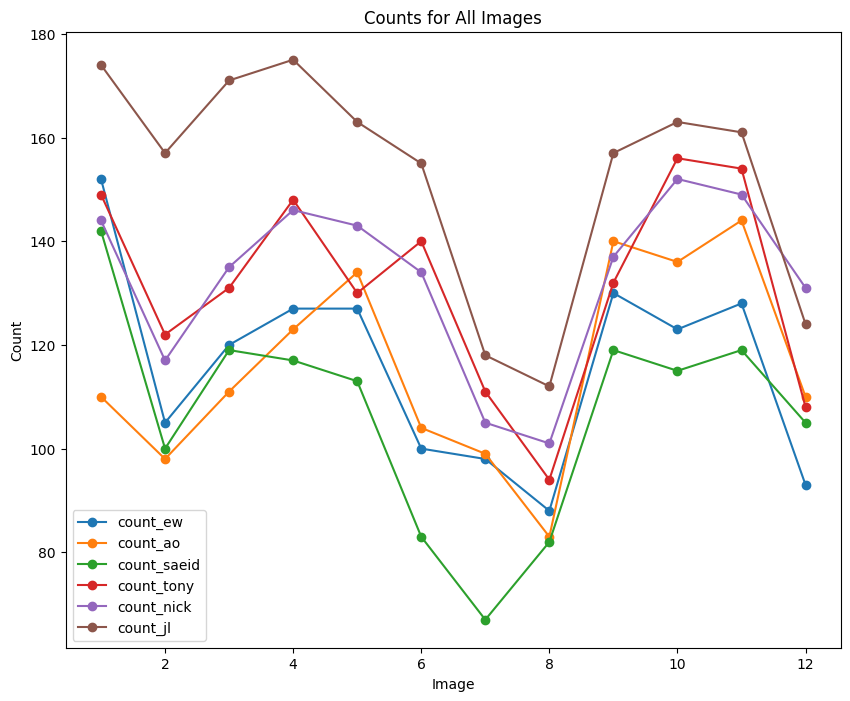

In [5]:
plt.figure(figsize=(10, 8))

# Plot each column as a line graph
for column in df_gt.columns:
    plt.plot(df_gt.index, df_gt[column], marker='o', label=column)

plt.title('Counts for All Images')
plt.xlabel('Image')
plt.ylabel('Count')
plt.legend()
plt.show()

From the figure above, we can see that, the counts from the six human counters vary greatly. While at the same time, people generally agree on the relative amount. This provides insight to the bubble counting task, which is that, if the model produces similar relative counts, then it would be considered a good model.   

## Image-by-Image Counts Distribution

<ipython-input-6-6a482dfda517>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(row.index, rotation=45)


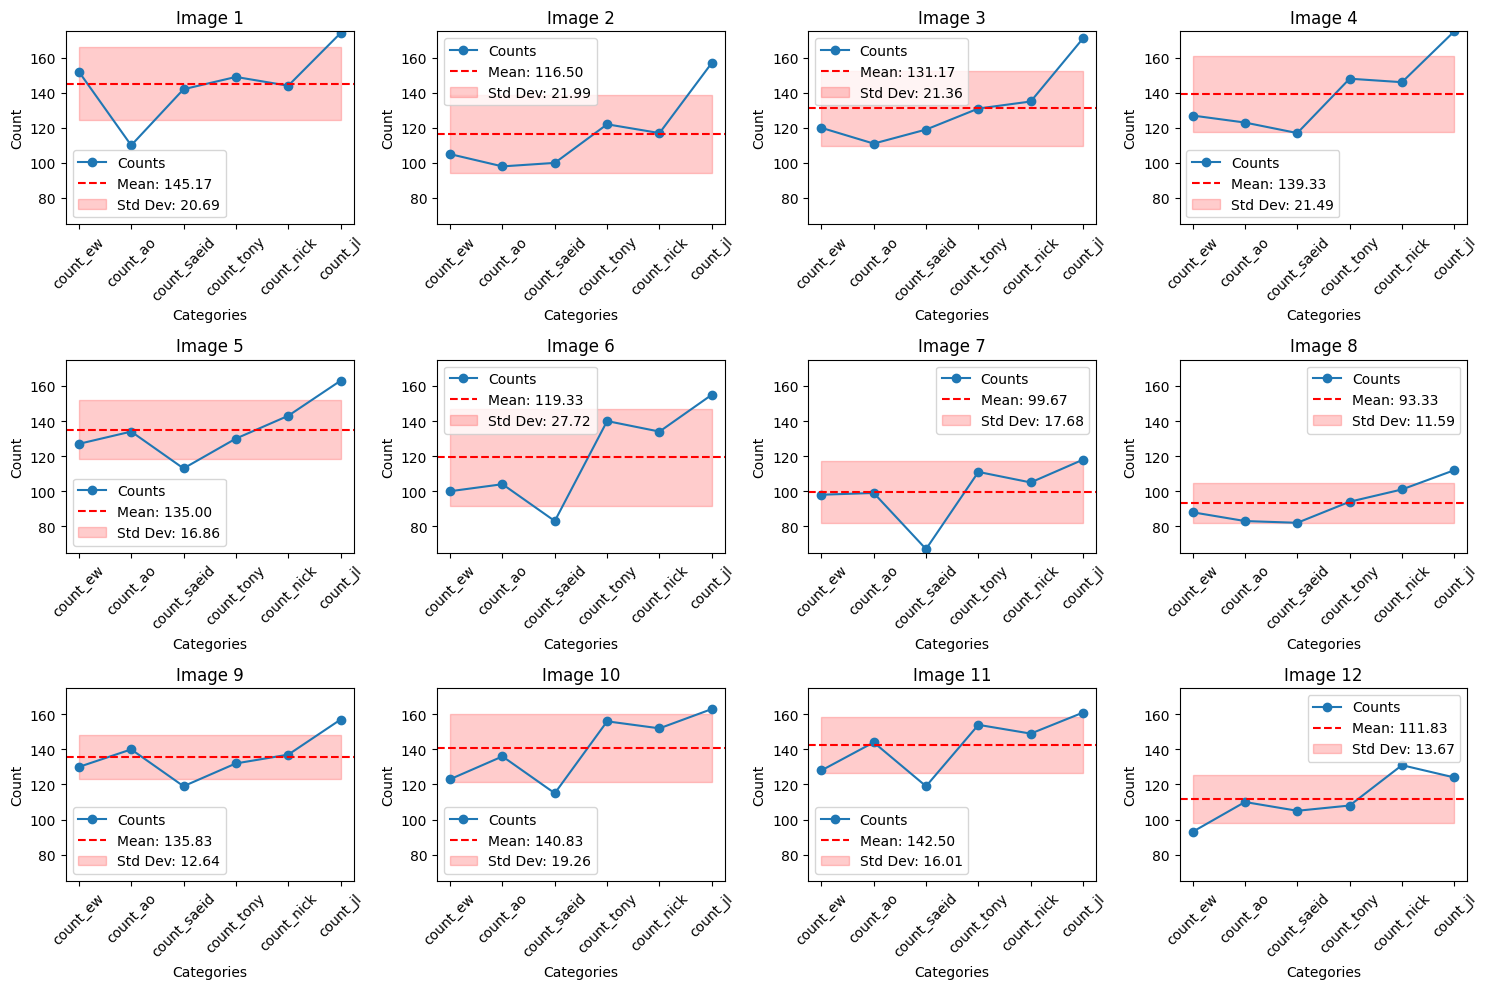

In [6]:
# Define the subplot layout
num_rows = 3
num_cols = 4

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

for idx, (image_index, row) in enumerate(df_gt.iterrows()):
    row_idx = idx // num_cols
    col_idx = idx % num_cols

    mean_value = row.mean()
    std_value = row.std()

    ax = axes[row_idx, col_idx]
    ax.plot(row, marker='o', label='Counts')
    ax.axhline(mean_value, color='r', linestyle='dashed', label=f'Mean: {mean_value:.2f}')
    ax.fill_between(row.index, mean_value - std_value, mean_value + std_value, color='r', alpha=0.2, label=f'Std Dev: {std_value:.2f}')
    ax.set_title(f'Image {image_index}')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Count')
    ax.set_ylim(65, 175)  # Set y-axis limits
    ax.set_xticklabels(row.index, rotation=45)
    ax.legend()

# Adjust layout and spacing
plt.tight_layout()
plt.show()

Above plots shows the different counts of each of the 12 sample images. The mean and standard deviation are shown on each. Specifically, images 7, 8, and 11 have low STD and it is making me think the bubbles in these images are less ambiguous.

While image 6 seems to have to largest STD. To observe the bubbles. They are expected to have a wide range of apperances.

Displaying Image 6 and Image 8


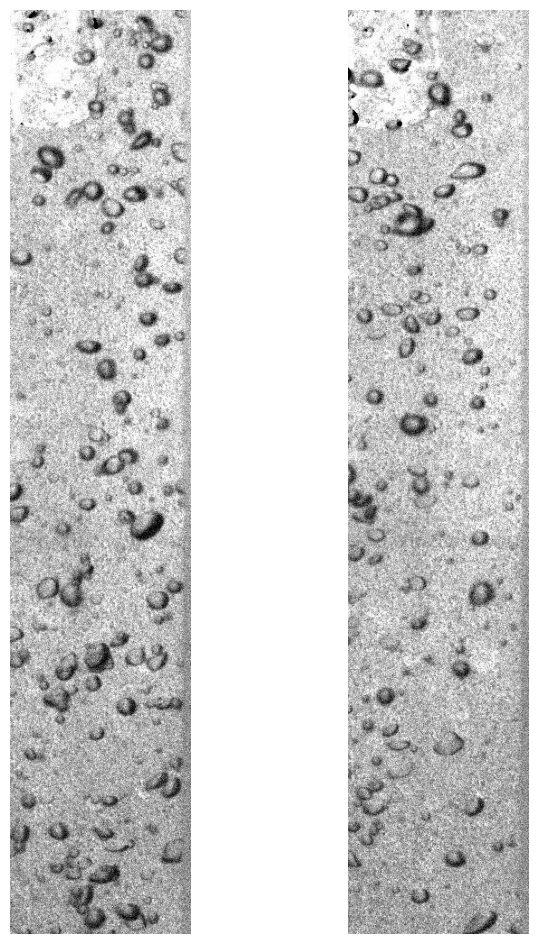

In [7]:
print("Displaying Image 6 and Image 8")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image6 = mpimg.imread('Targets/1_batch/12-09-22_SEN9_1.8_6_300-400_Test.781n5gky.000005_cropped.jpg')
image8 = mpimg.imread('Targets/1_batch/12-09-22_SEN9_1.8_6_300-400_Test.781n5gky.000007_cropped.jpg')

plt.figure(figsize=(8, 12))  # Adjust the figure size as needed

# Create the first subplot
plt.subplot(1, 2, 1)
plt.imshow(image6)
plt.axis('off')  # Hide the axes

# Create the second subplot
plt.subplot(1, 2, 2)
plt.imshow(image8)
plt.axis('off')  # Hide the axes

plt.show()


Looking at image 6 and image 8, we can *kind of* see that bubbles in image 8 have a much more consistent size distribution than image 6. This would make it easier for the human counters to come to an agreement of the overall number.  

In [8]:
# Adding mean and std to the df
df_gt['average'] = df_gt.mean(axis=1)
df_gt['std_dev'] = df_gt.std(axis=1)

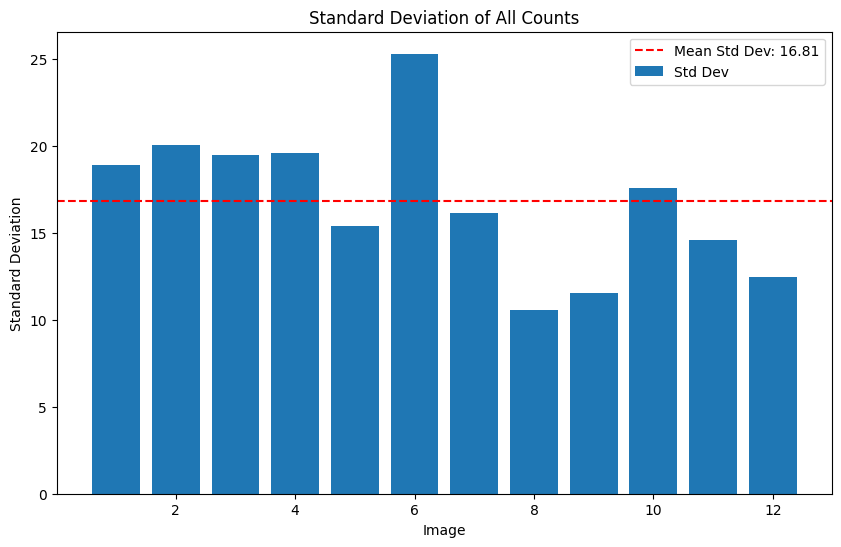

In [9]:
# Another perspective of the image-by-image

plt.figure(figsize=(10, 6))
plt.bar(df_gt.index, df_gt['std_dev'], label='Std Dev')
plt.axhline(df_gt['std_dev'].mean(), color='r', linestyle='dashed', label=f'Mean Std Dev: {df_gt["std_dev"].mean():.2f}')
plt.title('Standard Deviation of All Counts')
plt.xlabel('Image')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()

The standard deviation is somewhat consistent, especially if disregarding 5, 6 and 8. Maybe these image are inherently difficult to count.

This further demenstrated that regardless of the exact count, the relative counts of these 12 samples are comparable among the different counters. The bias between the counters, human or model, should be expected.

## (SS)Relative Counts

We can look at the relative counts of everybody by normalizing the counts with the mean.

In [10]:
# Calculate the relative counts
column_means = df_gt.mean()
df_normalized = df_gt.divide(column_means).iloc[:,:-2]  # Exclude 'average' and 'std_dev'

df_normalized

,count_ew,count_ao,count_saeid,count_tony,count_nick,count_jl
image,,,,,,
1,1.311287,0.948276,1.330211,1.135238,1.084065,1.140984
2,0.905823,0.844828,0.936768,0.929524,0.880803,1.029508
3,1.035226,0.956897,1.114754,0.998095,1.016311,1.121311
4,1.095615,1.060345,1.096019,1.127619,1.099122,1.147541
5,1.095615,1.155172,1.058548,0.990476,1.076537,1.068852
6,0.862689,0.896552,0.777518,1.066667,1.008783,1.016393
7,0.845435,0.853448,0.627635,0.845714,0.790464,0.773770
8,0.759166,0.715517,0.768150,0.716190,0.760351,0.734426
9,1.121495,1.206897,1.114754,1.005714,1.031368,1.029508


<ipython-input-11-1ebf9072ea97>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(row.index, rotation=45)


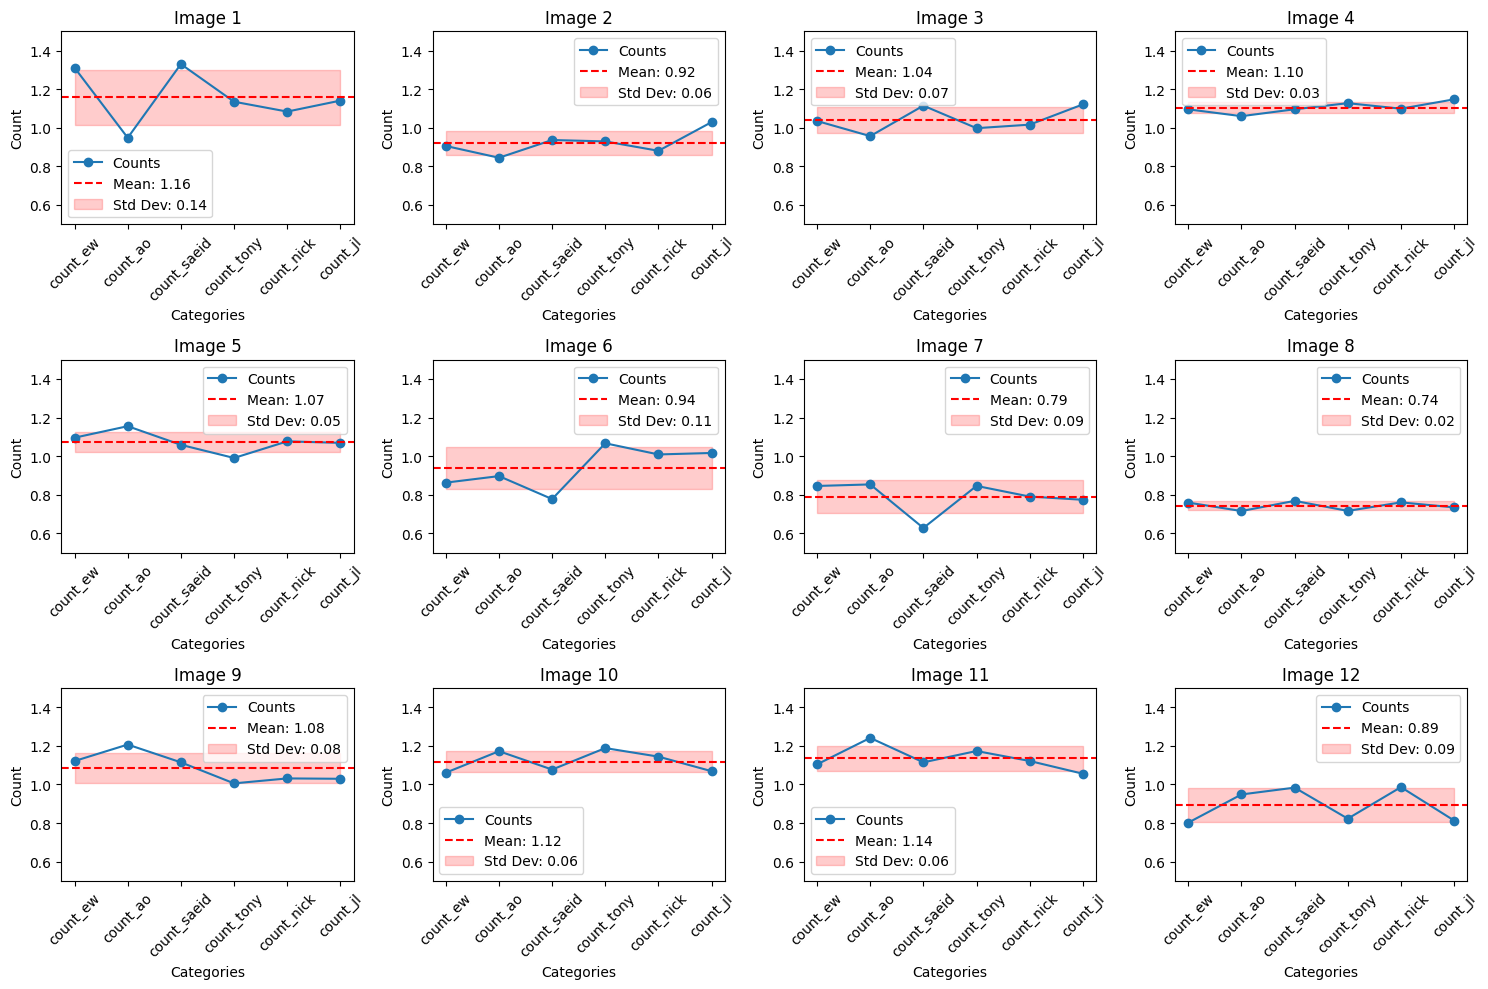

In [11]:
# Define the subplot layout
num_rows = 3
num_cols = 4
columns_to_plot = df_normalized.columns

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

for idx, (image_index, row) in enumerate(df_normalized[columns_to_plot].iterrows()):
    row_idx = idx // num_cols
    col_idx = idx % num_cols

    mean_value = row.mean()
    std_value = row.std()
    ax = axes[row_idx, col_idx]
    ax.plot(row, marker='o', label='Counts')
    ax.axhline(mean_value, color='r', linestyle='dashed', label=f'Mean: {mean_value:.2f}')
    ax.fill_between(row.index, mean_value - std_value, mean_value + std_value, color='r', alpha=0.2, label=f'Std Dev: {std_value:.2f}')
    ax.set_title(f'Image {image_index}')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Count')
    ax.set_ylim(0.5, 1.5)  # Set y-axis limits
    ax.set_xticklabels(row.index, rotation=45)
    ax.legend()

# Adjust layout and spacing
plt.tight_layout()
plt.show()

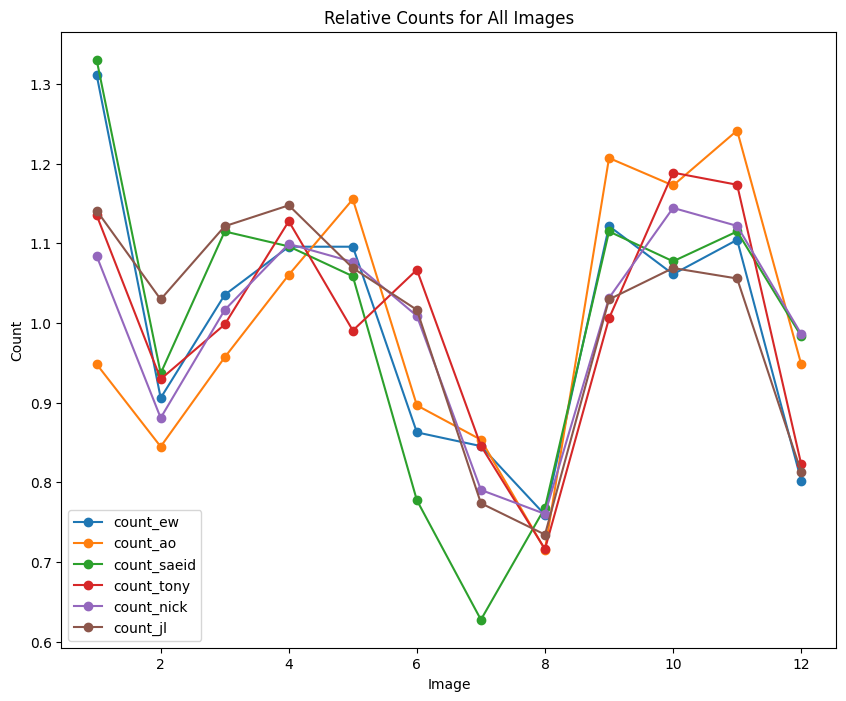

In [12]:
plt.figure(figsize=(10, 8))

# Plot each column as a line graph
for column in df_gt.columns[:-2]:
    plt.plot(df_gt.index, df_normalized[column], marker='o', label=column)

plt.title('Relative Counts for All Images')
plt.xlabel('Image')
plt.ylabel('Count')
plt.legend()
plt.show()

So, say we have the results from the counting model. There are two types of comparisons to make.
- 1) Comparing to the absolute counts and see if it is within the bounds of the human counts
- 2) Comparing to the relative (normalized) count and see if the counting model has a similar trend, which can be a metric for the quality of counts. We use the mean squared error calculated from comparing the model counts vs. the `df_normalized["average"]` .

The relative counts present a convencingly consistent trend, which shows that that human counters, despite the bias and disimilar definitions of bubbles, have similar ideas in terms of the relative amounts between the images. As for the purpose of the bubble counting task, it would be satisfactory if the model performs similarly to the human counters, in the sense that it also counts with a consistent bias.

# Preparation
Initialize counting model, arguments and misc helper function

In [13]:
from BubbleCount.counting_model import CountingPipe
model = CountingPipe()  # Only really need the count_hybrid() function in this notebook

===> Using GPU mode.



In [22]:
args = {
    "sample_path": "Exemplars/",
    "target_path": "Targets/1_batch/",
    "result_path_1": "Outputs/EXP1_Output.csv",
    "result_path_2": "Outputs/EXP2_Output.csv",
    "result_path_3": "Outputs/2_4_exemps_output.csv",
    "output_dir": "Outputs/",
    # "model_path": "./data/pretrainedModels/FamNet_Save1.pth",
    "ground_truth_path": "Targets/1-Batch Manual Counts/SEN9_1.8_6_300-400_Test/GroundTruth.csv"
}

In [15]:
# Helper function for breaking down the image names
def simplify_target_name(target):
    temp = target.split('_')[1:-1]
    temp = '_'.join(temp)
    serial_number = temp.split('.')[-1]
    batch_name = '.'.join(temp.split('.')[0:-2])

    return f"{batch_name}_{serial_number}"

# EXP1: Investigate Counting Quality:(aka. **Default vs. Ground Truth**)

This experiment focuses on the result comparisons between the default model and the ground truth.

There are 2 sets of exemplars and 10 target images. Recorded the count; produced the resulting image.

Exemplars are saved in the "Exemplars" directory, the target directory is "Targets", and the results are saved in the "Outputs".

The following functions are developed to load the images and bounding boxes into their respective containers.<br>
Use the functions in `image_preprocess`:
- `load_exemplars_from_directory`
- `load_target_images_from_directory`

The containers look like the following:
```
exemplar_data = [{'file_name': file_name, 'image': image_data, 'box': bbox_data}]
```
```
Targets = [{"file_name": file_name, "image": image}]
```

TODO: Make sure the above is saved in doc strings

##Main Pipeline
Uncomment this section if desired

In [16]:
# # Main Pipeline
# result_to_csv = []

# # Load exemplars and targets
# Exemplars = image_preprocess.load_exemplars_from_directory(args["sample_path"])
# Targets = image_preprocess.load_target_images_from_directory(args["target_path"])

# for sample_image in Exemplars:
#     for target_image in Targets:

#         # Creating the hybrid
#         hybrid, hybrid_boxes = image_preprocess.insert_cropped(sample_image['image'], target_image['image'], sample_image['box'])

#         # counting
#         hybrid_count = model.count_hybrid(hybrid, hybrid_boxes, sample_image["file_name"], target_image["file_name"])

#         result_to_csv.append([sample_image['file_name'], target_image['file_name'], hybrid_count])

# csv_header = ["exemplar_file_name", "target_file_name", "hybrid_count"]
# csv_helpers.backup_and_clear_csv(args["result_path_1"])
# csv_helpers.save_to_csv(result_to_csv, args["result_path_1"])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 107MB/s]


===> The predicted count for 12-09-22_SEN9_1.8_6_300-400_Test.781n5gky.000011_cropped.jpg is:  77.79
===> The predicted count for 12-09-22_SEN9_1.8_6_300-400_Test.781n5gky.000002_cropped.jpg is:  70.27
===> The predicted count for 12-09-22_SEN9_1.8_6_300-400_Test.781n5gky.000003_cropped.jpg is:  91.98
===> The predicted count for 12-09-22_SEN9_1.8_6_300-400_Test.781n5gky.000004_cropped.jpg is: 104.35
===> The predicted count for 12-09-22_SEN9_1.8_6_300-400_Test.781n5gky.000005_cropped.jpg is:  73.18
===> The predicted count for 12-09-22_SEN9_1.8_6_300-400_Test.781n5gky.000006_cropped.jpg is:  60.04
===> The predicted count for 12-09-22_SEN9_1.8_6_300-400_Test.781n5gky.000007_cropped.jpg is:  53.98
===> The predicted count for 12-09-22_SEN9_1.8_6_300-400_Test.781n5gky.000008_cropped.jpg is:  64.49
===> The predicted count for 12-09-22_SEN9_1.8_6_300-400_Test.781n5gky.000009_cropped.jpg is: 118.07
===> The predicted count for 12-09-22_SEN9_1.8_6_300-400_Test.781n5gky.000010_cropped.jpg i

## Process Result

In [17]:
%matplotlib inline
df = pd.read_csv(args['result_path_1'])

In [18]:
df.head()

,Exemplar,Target,Count
0,exemp2,12-09-22_SEN9_1.8_6_300-400_Test.781n5gky.0000...,77.792145
1,exemp2,12-09-22_SEN9_1.8_6_300-400_Test.781n5gky.0000...,70.270973
2,exemp2,12-09-22_SEN9_1.8_6_300-400_Test.781n5gky.0000...,91.983017
3,exemp2,12-09-22_SEN9_1.8_6_300-400_Test.781n5gky.0000...,104.352577
4,exemp2,12-09-22_SEN9_1.8_6_300-400_Test.781n5gky.0000...,73.177788


In [19]:
# Simplify the Target column to only the image number
df['Target'] = df['Target'].str.split('.').str[-2].str.split("_").str[0].astype(int)
# df['Count'] = df['Count'].astype(int)
df = df.sort_values(by='Target', ascending=True)

In [20]:
df.head()

,Exemplar,Target,Count
1,exemp2,2,70.270973
11,exemp1,2,125.895142
2,exemp2,3,91.983017
12,exemp1,3,175.023972
3,exemp2,4,104.352577


Include the manual counts in the figure

In [23]:
df_ground = pd.read_csv(args["ground_truth_path"], index_col=0)
df_ground.head()

,count_ew,count_ao,count_saeid,count_tony,count_nick,count_jl
image,,,,,,
0,152,110,142,149,144,174
1,105,98,100,122,117,157
2,120,111,119,131,135,171
3,127,123,117,148,146,175
4,127,134,113,130,143,163


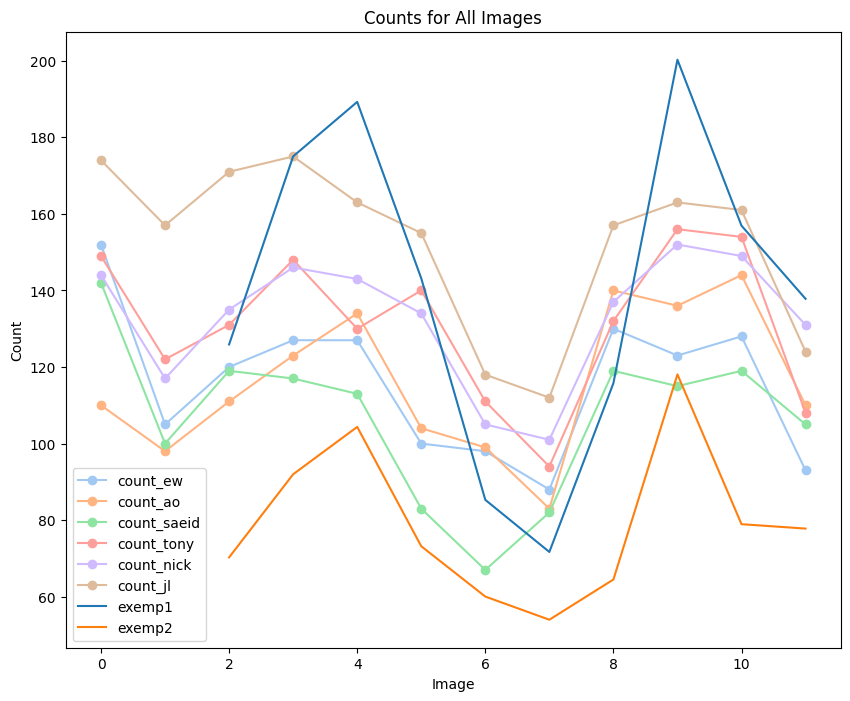

In [24]:
pastel_colors = sns.color_palette("pastel", n_colors=len(df_ground.columns))

plt.figure(figsize=(10, 8))

# Plot each column as a line graph with pastel colors
for i, column in enumerate(df_ground.columns):
    plt.plot(df_ground.index, df_ground[column], marker='o', label=column, color=pastel_colors[i])

for name, group in df.groupby('Exemplar'):
    plt.plot(group['Target'], group['Count'], label=name)

plt.title('Counts for All Images')
plt.xlabel('Image')
plt.ylabel('Count')
plt.legend()
plt.show()


Conclusion:

The model produces similarly consistent trend

TODO:
- calculate some metrics
 - something like the deviation of the normalized counts from the mean of human counts (or just a graph)

# EXP2: Investigate Effect of Number of Exemplars (aka **set2 vs. set4 vs. set6**)

For each exemplar images, 6 bubble exemplars have been identified and the coordinates are saved in the "_box.txt" files. The following section looks at the effect of having different number of exemplars embeded in the hybrid image to the quality of counting.

Used both sample(exemplar) images and included 2, 4, or 6 exemplars in the hybrid images. All results will be recorded and plotted.

## Main Pipeline
Uncomment this section if desired

In [ ]:
# result_to_csv = []

# # Load exemplars and targets
# Exemplars = image_preprocess.load_exemplars_from_directory(args["sample_path"])
# Targets = image_preprocess.load_target_images_from_directory(args["target_path"])

# for sample_image in Exemplars:
#     for target_image in Targets:
#         for num_exemps in [2,4,6]:
#             # Creating the hybrid
#             hybrid, hybrid_boxes = image_preprocess.insert_cropped(sample_image['image'], target_image['image'], sample_image['box'], num_exemps)
#             target_name = f"{simplify_target_name(target_image['file_name'])}_{num_exemps}exemps"

#             # counting
#             hybrid_count = model.count_hybrid(hybrid, hybrid_boxes, sample_image["file_name"], target_name)

#             result_to_csv.append([sample_image['file_name'], num_exemps, target_name, hybrid_count])

# csv_header = ["Exemplar", "num_exemps","Target", "Count"]
# csv_helpers.backup_and_clear_csv(args["result_path_2"])
# csv_helpers.save_to_csv(result_to_csv, args["result_path_2"], csv_header)

## Process Result

In [ ]:
df2 = pd.read_csv(args['result_path_2'])
df2.head()

,Exemplar,num_exemps,Target,Count
0,exemp1,2,SEN9_1.8_6_300-400_Test_000011_2exemps,201.193863
1,exemp1,4,SEN9_1.8_6_300-400_Test_000011_4exemps,137.817780
2,exemp1,6,SEN9_1.8_6_300-400_Test_000011_6exemps,70.514183
3,exemp1,2,SEN9_1.8_6_300-400_Test_000002_2exemps,210.323929
4,exemp1,4,SEN9_1.8_6_300-400_Test_000002_4exemps,125.895142


In [ ]:
df2['serial'] = df2['Target'].apply(lambda x: int(x.split("_")[5]))
df2.head()

,Exemplar,num_exemps,Target,Count,serial
0,exemp1,2,SEN9_1.8_6_300-400_Test_000011_2exemps,201.193863,11
1,exemp1,4,SEN9_1.8_6_300-400_Test_000011_4exemps,137.817780,11
2,exemp1,6,SEN9_1.8_6_300-400_Test_000011_6exemps,70.514183,11
3,exemp1,2,SEN9_1.8_6_300-400_Test_000002_2exemps,210.323929,2
4,exemp1,4,SEN9_1.8_6_300-400_Test_000002_4exemps,125.895142,2


In [ ]:
df2 = df2.sort_values(by=['Exemplar', 'num_exemps', 'serial'])

df2_grouped = df2.groupby(['Exemplar', 'num_exemps'])
exemplars = pd.unique(df2['Exemplar'])
exemp_nums = pd.unique(df2['num_exemps'])
LINESTYLE = ['-','--']
COLORS = ['blue', 'orange', 'red']

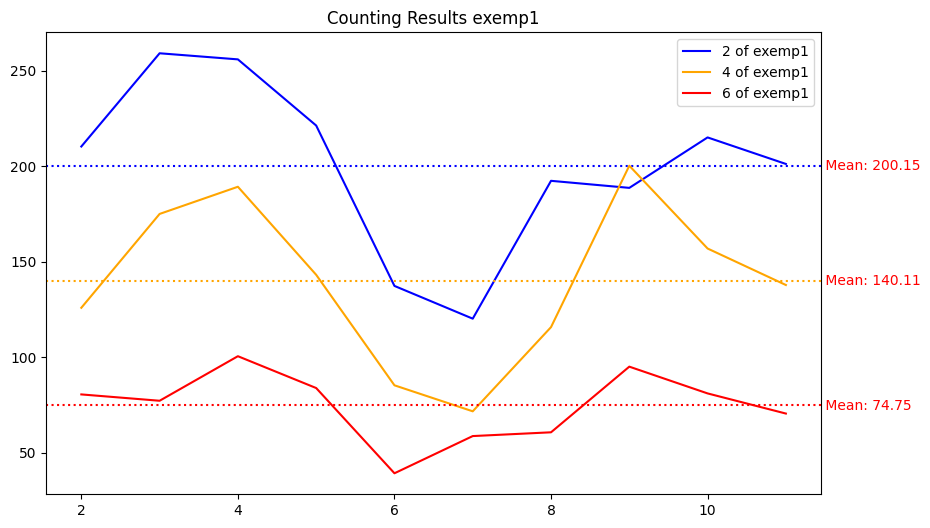

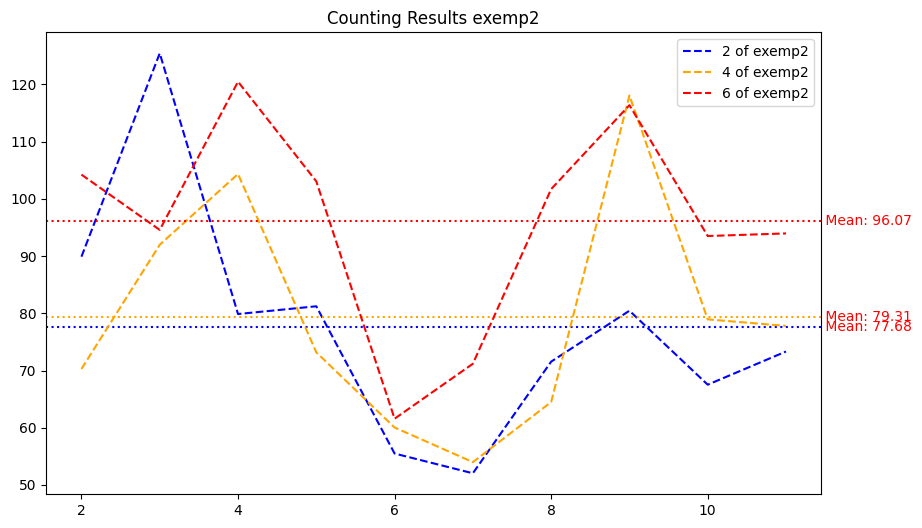

In [ ]:
for index_exemp, exemp in enumerate(exemplars):
    plt.figure(figsize=(10, 6))
    for index_num, n in enumerate(exemp_nums):
        df_set = df2_grouped.get_group((exemp, n))
        plt.plot(df_set['serial'], df_set['Count'], label=f"{n} of {exemp}", color=COLORS[index_num], linestyle=LINESTYLE[index_exemp])

        mean_value = df_set['Count'].mean()
        plt.axhline(mean_value, color=COLORS[index_num], linestyle=':')
        # Add text label for the mean value above the horizontal line
        plt.text(plt.xlim()[1], mean_value, f" Mean: {mean_value:.2f}", color='r', va='center', ha='left')


    plt.title(f"Counting Results {exemp}")
    plt.legend()
    plt.show()

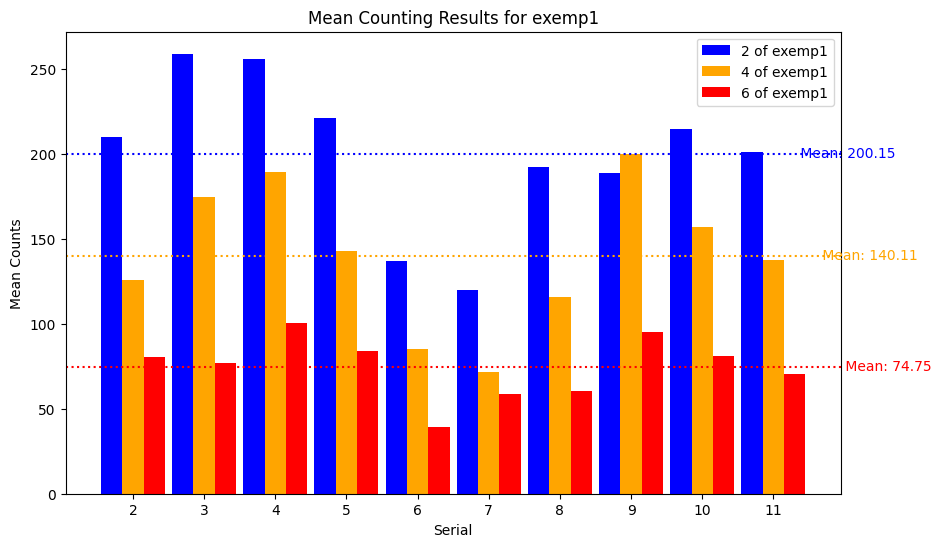

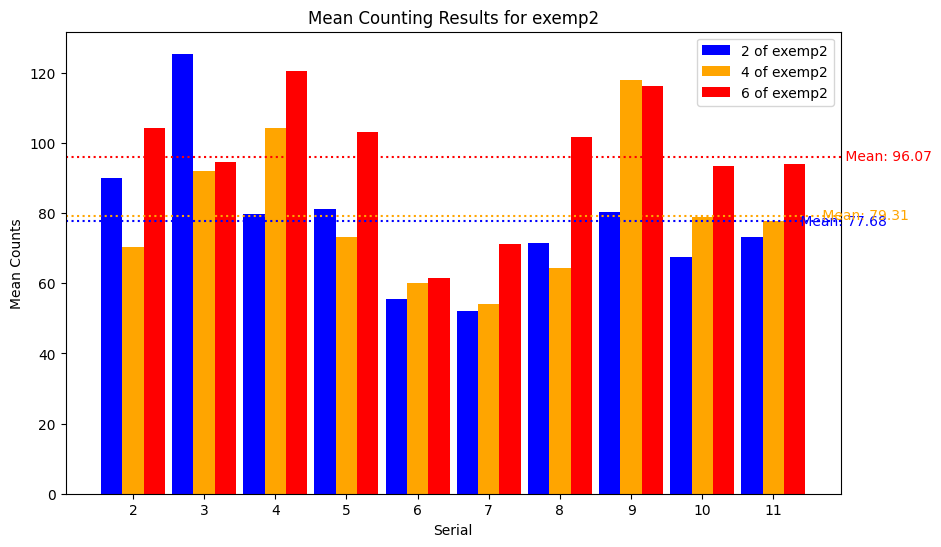

In [ ]:
for index_exemp, exemp in enumerate(exemplars):
    plt.figure(figsize=(10, 6))
    bar_width = 0.3

    for index_num, n in enumerate(exemp_nums):
        df_set = df2_grouped.get_group((exemp, n))

        x_offsets = df_set['serial'] + index_num * bar_width
        plt.bar(x_offsets, df_set['Count'], bar_width, label=f"{n} of {exemp}", color=COLORS[index_num])
        mean_value = df_set['Count'].mean()
        plt.axhline(mean_value, color=COLORS[index_num], linestyle=':')
        plt.text(plt.xlim()[1], mean_value, f" Mean: {mean_value:.2f}", color=COLORS[index_num], va='center', ha='left')

    plt.xlabel('Serial')
    plt.ylabel('Mean Counts')
    plt.title(f"Mean Counting Results for {exemp}")
    plt.xticks(df_set['serial'] + bar_width * (len(exemp_nums) - 1) / 2, df_set['serial'].unique())
    plt.legend()
    plt.show()


There are quite some differences between the sets, when using different number of exemplars. They do still seem to have a somewhat consistent bias. Comparing the two sets of exemplars below, it is hard to say what caused the issue.

We do know from the Paper, it shows that even having 1 exemplar, the model produces great counting results. And with more exemplars, it should produce more accurate counts.

Although, our bubble images, unlike the image set used in the paper, introduces great variations in terms of the appearances of the bubbles. While also keeping in mind that the model utilizes the **correlation map** between the exemplars, which means, having a variety of shapes of bubbles would actually reduce the understanding of what a typical bubble look like to the model.  

Look at the first exemplar image:


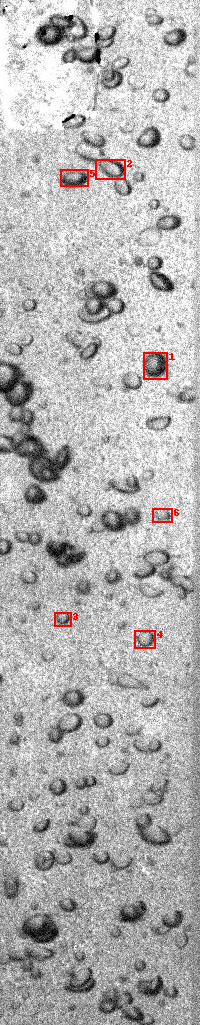


Look at the second exemplar image:


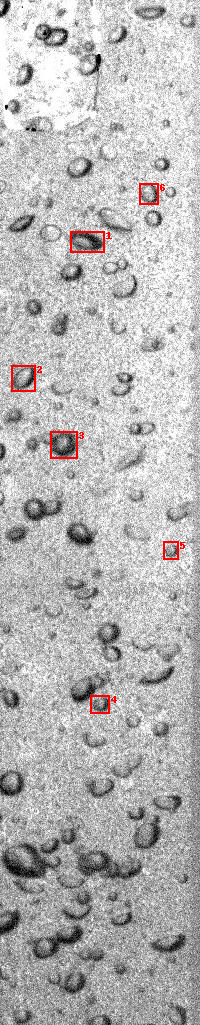

In [ ]:
print("Look at the first exemplar image:")
image_preprocess.draw_rectangles_on_image('Exemplars/exemp1.jpg', 'Exemplars/exemp1_box.txt')
print("\nLook at the second exemplar image:")
image_preprocess.draw_rectangles_on_image('Exemplars/exemp2.jpg', 'Exemplars/exemp2_box.txt')

# EXP3 Effect of Choosing Different Exemplars for the sets of 2 and sets of 4 (aka. **Different selections of set2 and set4**)
Want to see how much different would the counts be if the 2 and 4 exemplars are chosen to be different than before.

The experiment focuses on including different exemplars from the image in the set of 2 or 4. This is accomplished by reversing the orders of the bounding boxes, which resulted in taking the (1st, 2nd) and (1st, 2nd, 3rd, and 4th) for **set 1** and (5th, 6th), (3rd, 4th, 5th, 6th) for **set 2**

There are other ways of producing different (more random) sets of exemplars. For example, We can pick randomly from the permutations of the exemplars. This is not included, since the results would be heavily dependent on the bubble exemplars. it is not expected to observe generalizing properties of the model or algorithm.

## Pipeline
Uncomment this section if desired


In [ ]:
# result_to_csv = []

# for is_reverse in [False, True]:
#     # Load exemplars and targets
#     Exemplars = image_preprocess.load_exemplars_from_directory(args["sample_path"], reverse_bbox=is_reverse)
#     Targets = image_preprocess.load_target_images_from_directory(args["target_path"])

#     for sample_image in Exemplars:
#         for target_image in Targets:
#             for num_exemps in [2,4]:
#                 # Creating the hybrid
#                 hybrid, hybrid_boxes = image_preprocess.insert_cropped(sample_image['image'], target_image['image'], sample_image['box'], num_exemps)
#                 target_name = f"{simplify_target_name(target_image['file_name'])}_{num_exemps}exemps_rev{is_reverse}"

#                 # counting
#                 hybrid_count = model.count_hybrid(hybrid, hybrid_boxes, sample_image["file_name"], target_name)

#                 result_to_csv.append([sample_image['file_name'], num_exemps, is_reverse, target_name, hybrid_count])

# csv_header = ["Exemplar", "num_exemps", "rev_bbox", "Target", "Count"]
# csv_helpers.backup_and_clear_csv(args["result_path_3"])
# csv_helpers.save_to_csv(result_to_csv, args["result_path_3"], csv_header)

## Process Result

In [ ]:
df3 = pd.read_csv(args['result_path_3'])
df3

,Exemplar,num_exemps,rev_bbox,Target,Count
0,exemp1,2,False,SEN9_1.8_6_300-400_Test_000011_2exemps_revFalse,201.193863
1,exemp1,4,False,SEN9_1.8_6_300-400_Test_000011_4exemps_revFalse,137.817780
2,exemp1,2,False,SEN9_1.8_6_300-400_Test_000002_2exemps_revFalse,210.323929
3,exemp1,4,False,SEN9_1.8_6_300-400_Test_000002_4exemps_revFalse,125.895142
4,exemp1,2,False,SEN9_1.8_6_300-400_Test_000003_2exemps_revFalse,259.135742
...,...,...,...,...,...
75,exemp2,4,True,SEN9_1.8_6_300-400_Test_000008_4exemps_revTrue,33.921051
76,exemp2,2,True,SEN9_1.8_6_300-400_Test_000009_2exemps_revTrue,155.125839
77,exemp2,4,True,SEN9_1.8_6_300-400_Test_000009_4exemps_revTrue,60.142197
78,exemp2,2,True,SEN9_1.8_6_300-400_Test_000010_2exemps_revTrue,205.656982


In [ ]:
df3['serial'] = df3['Target'].apply(lambda x: int(x.split("_")[5]))

In [ ]:
df3 = df3.sort_values(by=["serial"])

df3_grouped = df3.groupby(['Exemplar', 'num_exemps', 'rev_bbox'])
exemplars = pd.unique(df3['Exemplar'])
exemp_nums = pd.unique(df3['num_exemps'])

In [ ]:
COLORS = ["orange", "blue"]
LINESTYLE = ['-','--']
LABELS = ["Set", "Reversed Set"]

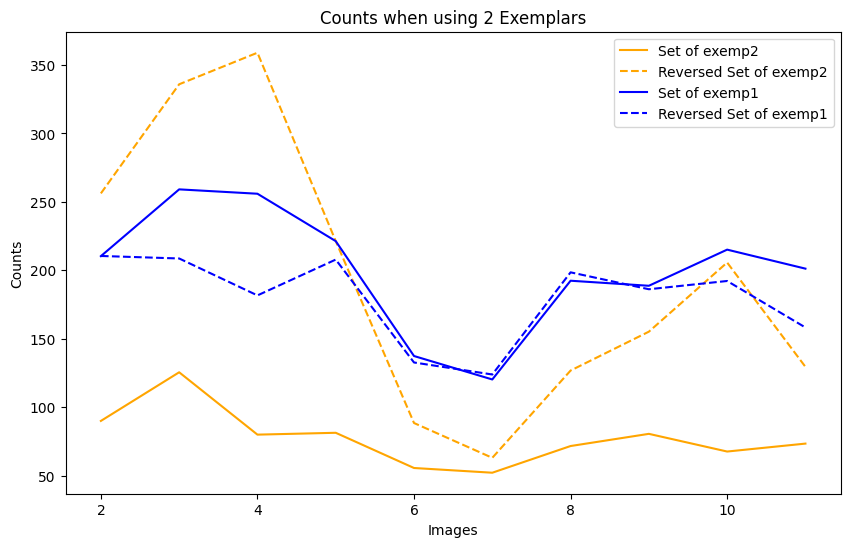

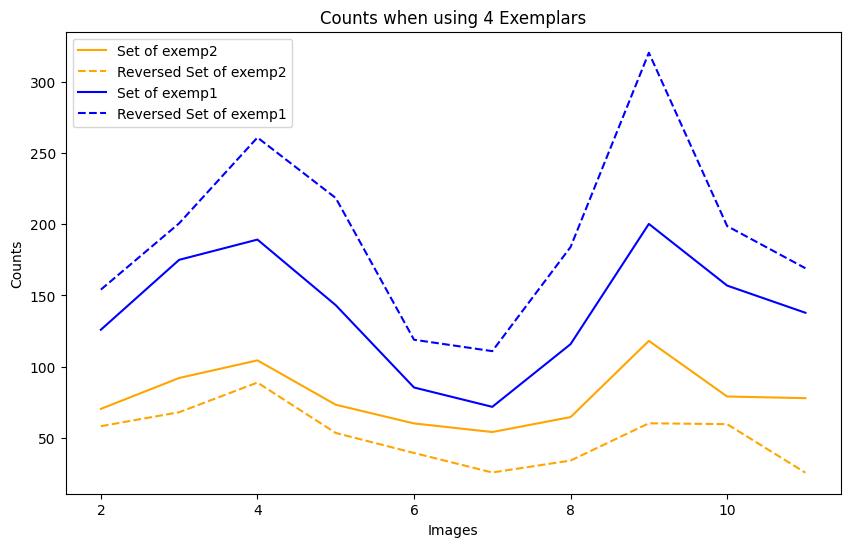

In [ ]:
for n in exemp_nums:
    plt.figure(figsize=(10,6))
    for idx_e, exemp in enumerate(exemplars):
        for idx_r, reversed in enumerate([False, True]):
            df_set = df3_grouped.get_group((exemp, n, reversed))
            plt.plot(df_set['serial'], df_set['Count'], label=f"{LABELS[idx_r]} of {exemp}", color=COLORS[idx_e], linestyle=LINESTYLE[idx_r])

    plt.title(f"Counts when using {n} Exemplars")
    plt.xlabel('Images')
    plt.ylabel('Counts')
    plt.legend()
    plt.show()

The conclusion from above experiment seems to be that, there definitely are variations regarding to the counts depending on the exemplars to include, (not surprisingly).

Also not surprisingly, when the exemplars taken are entirely different, i.e., set 1 with 2 exemplars, the counting results can be very different.

It is promising to see, when having 4 exemplars, even though the exemplars are not exactly the same, the counting results follow a consistent trend. -> we can say that, the counting model is more stable with more exemplars (4 or 6)

# Compare All Model Counts with Ground Truth

## Plotting the EXP with Ground Truth

In [ ]:
df2 = df2.sort_values(by=['Exemplar', 'num_exemps', 'serial'])

df2_grouped = df2.groupby(['Exemplar', 'num_exemps'])
exemplars = pd.unique(df2['Exemplar'])
exemp_nums = pd.unique(df2['num_exemps'])

In [ ]:
COLORS = ["blue", "red"]
LINESTYLE = [':','--','-']
LABELS = ["Set 1", "Set 2 (Reversed)"]

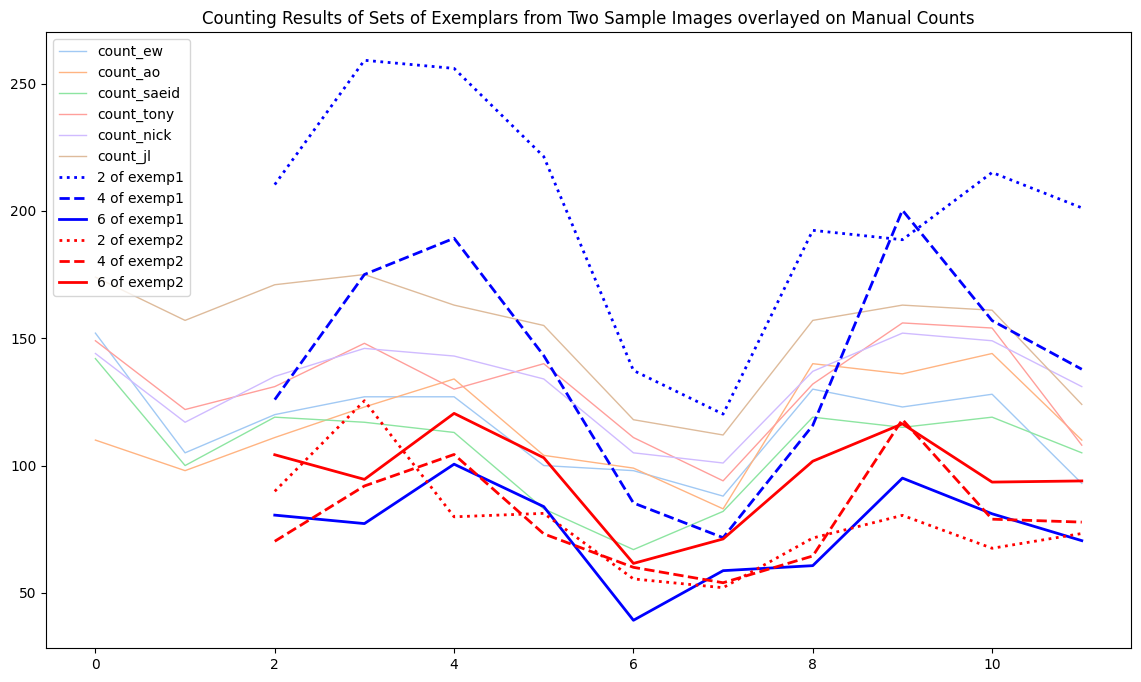

In [ ]:
df_ground = pd.read_csv(args["ground_truth_path"], index_col=0)
df_ground.head()
pastel_colors = sns.color_palette("pastel", n_colors=len(df_ground.columns))

plt.figure(figsize=(14, 8))
for i, column in enumerate(df_ground.columns):
    plt.plot(df_ground.index, df_ground[column], linewidth=1, label=column, color=pastel_colors[i])

for index_exemp, exemp in enumerate(exemplars):
    for index_num, n in enumerate(exemp_nums):
        df_set = df2_grouped.get_group((exemp, n))
        plt.plot(df_set['serial'], df_set['Count'], linewidth=2, label=f"{n} of {exemp}", color=COLORS[index_exemp], linestyle=LINESTYLE[index_num])

plt.title("Counting Results of Sets of Exemplars from Two Sample Images overlayed on Manual Counts")
plt.legend()
plt.show()

Looks like,
- Having 6 exemplars produces the trends/biases that are more similar to manual counts.
- Exemplar Image 2 seems to be more reliable, and less volatile, and is the preferred exemplar image.


## Calculating Normalized Mean Square Error

In [ ]:
# Put counts from all different experiment configurations to one dataframe
counts_w_config = pd.DataFrame(index=df2["serial"].unique())
exemplars = df2['Exemplar'].unique()

# From df2
num_exemps = df2['num_exemps'].unique()
for exemplar in exemplars:
    for num_e in num_exemps:
        column_name = f'set{num_e}_{exemplar}'

        filtered_df = df2[(df2['Exemplar'] == exemplar) & (df2['num_exemps'] == num_e)]

        counts_w_config[column_name] = filtered_df.set_index('serial')['Count']

# From df3
num_exemps = df3['num_exemps'].unique()
for exemplar in exemplars:
    for num_e in num_exemps:
        for is_rev in [True, False]:
            if is_rev:
                column_name = f'set{num_e}_{exemplar}_rev'

                filtered_df = df3[(df3['Exemplar'] == exemplar) & (df3['num_exemps'] == num_e) & (df3['rev_bbox'] == is_rev)]

                counts_w_config[column_name] = filtered_df.set_index('serial')['Count']

counts_w_config

,set2_exemp1,set4_exemp1,set6_exemp1,set2_exemp2,set4_exemp2,set6_exemp2,set2_exemp1_rev,set4_exemp1_rev,set2_exemp2_rev,set4_exemp2_rev
2,210.323929,125.895142,80.532425,89.895935,70.270973,104.240898,210.458954,154.097351,256.190796,58.100727
3,259.135742,175.023972,77.213287,125.449890,91.983017,94.575409,208.621826,200.702209,335.943542,67.907494
4,255.943451,189.251953,100.539680,79.872513,104.352577,120.484390,181.634644,260.992737,359.006256,88.756920
5,221.309570,143.159698,83.874725,81.226517,73.177788,103.065796,207.811157,218.489716,221.322754,53.335136
6,137.335114,85.300827,39.245926,55.489246,60.035881,61.574142,132.605484,118.862457,88.365494,39.258514
7,120.191223,71.688362,58.726418,52.036247,53.984898,71.177704,123.825684,110.847038,62.928261,25.546726
8,192.361725,115.766617,60.697876,71.547417,64.488647,101.706581,198.493042,184.043610,126.707985,33.921051
9,188.671112,200.271545,95.068710,80.450058,118.071571,116.379730,186.136719,320.599548,155.125839,60.142197
10,215.084091,156.919907,81.057785,67.520737,78.941299,93.506485,192.174866,198.762421,205.656982,59.511913
11,201.193863,137.817780,70.514183,73.319794,77.792145,93.961533,158.186005,169.117615,129.425507,25.384647


In [ ]:
df_ground['mean'] = df_ground.mean(axis=1)
mean_ground_truth = df_ground['mean'][2:12]  # Excluding the exemplar images

In [ ]:
mean_ground_truth

image
2     131.166667
3     139.333333
4     135.000000
5     119.333333
6      99.666667
7      93.333333
8     135.833333
9     140.833333
10    142.500000
11    111.833333
Name: mean, dtype: float64

In [ ]:
nmse_list = []
for exp_config, data in counts_w_config.items():
    nmse = get_normalized_mse(mean_ground_truth, data)
    nmse_list.append({'EXP Config': exp_config, 'NMSE': nmse})

nmse_results = pd.DataFrame(nmse_list)

In [ ]:
nmse_results

,EXP Config,NMSE
0,set2_exemp1,0.019451
1,set4_exemp1,0.037693
2,set6_exemp1,0.028331
3,set2_exemp2,0.039708
4,set4_exemp2,0.032549
5,set6_exemp2,0.012970
6,set2_exemp1_rev,0.008274
7,set4_exemp1_rev,0.054774
8,set2_exemp2_rev,0.172907
9,set4_exemp2_rev,0.089112


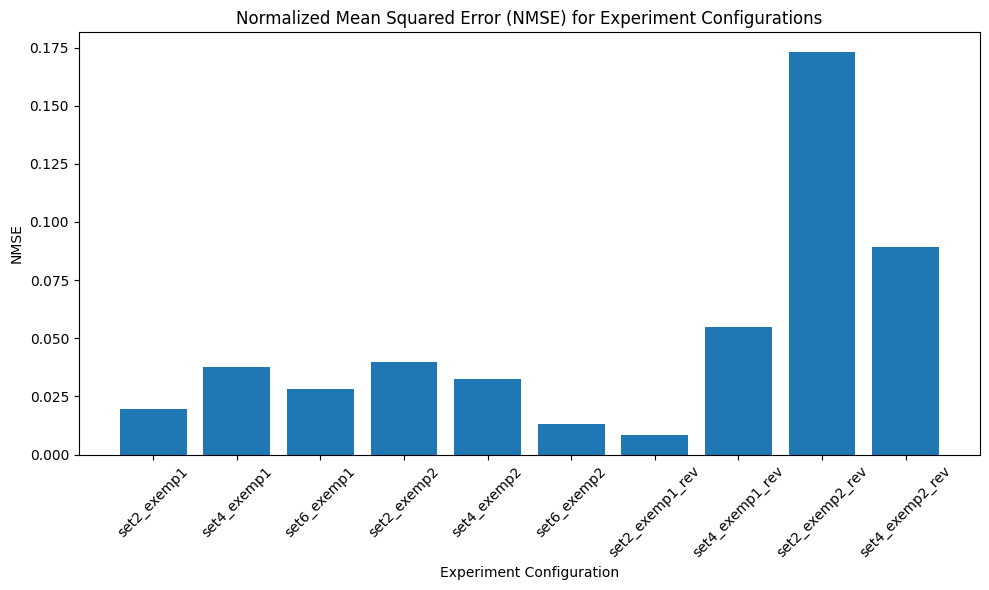

In [ ]:
plt.figure(figsize=(10, 6))  # Set the figure size as needed
plt.bar(nmse_results['EXP Config'], nmse_results['NMSE'])
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.xlabel('Experiment Configuration')
plt.ylabel('NMSE')
plt.title('Normalized Mean Squared Error (NMSE) for Experiment Configurations')
plt.tight_layout()

From the above bar chart, it is shown that, set6 with the second exemplar perform the best. Comparing the values from the reversed sets, it is shown that the selection of exemplars matters greatly. This is expected as the first 4 exemplars in the lists were chosen to be representative of the variety of the shapes and sizes of the bubbles, while the 5th and 6th were more repetitive when selected. Also, even though the `set_exemp1_rev` gives the lowest NMSE, it is to be reminded that this is for 10 images from one batch, and it is reasonable to avoid using a set of two exemplars since it may vary greatly, as shown in the comparison of `set2_exemp2` vs `set2_exemp2_rev`

## Quick Sanity Check of the NMSE Values
To establish a robust benchmark for interpreting the Normalized Mean Squared Error (NMSE), each NMSE value for manual counts was calculated by comparing one set of manual counts to the mean values derived from the remaining five sets. This methodology involves excluding the target manual counts while computing the mean, ensuring that each NMSE assessment reflects the comparison between a specific set of manual counts and the mean values derived from a representative sample of the remaining counts. This approach aims to provide a reliable baseline for evaluating the model's performance relative to the mean of the manual counts.

In [ ]:
df_ground = pd.read_csv(args["ground_truth_path"], index_col=0)

In [ ]:
def get_benchmark_nmse(df_ground, target_col:str):
    """caclulate the nmse of one of the six results compared to the remaining five"""
    df_ground_remaining = df_ground.drop(columns=[target_col])
    target = df_ground[target_col]
    mean = df_ground_remaining.mean(axis=1)

    return get_normalized_mse(target, mean)

In [ ]:
temp_NMSE_manuals = []

for counter in df_ground.columns.tolist():
    mnse = get_benchmark_nmse(df_ground, counter)
    temp_NMSE_manuals.append({"Counter": counter, "MNSE": mnse})

MNSE_manuals = pd.DataFrame(temp_NMSE_manuals)
MNSE_manuals

,Counter,MNSE
0,count_ew,0.005799
1,count_ao,0.012404
2,count_saeid,0.011995
3,count_tony,0.005286
4,count_nick,0.002965
5,count_jl,0.005288
